Имея данные продаж за пол года, мне нужно было сделать перераспределение остатков товара для текущего момента, а также выделить
позиции неликвидного товара.
Вся сложность заключается в ограниченности этих данных. У меня есть только несколько excel файлов. В каждом из них содержиться информация за 
один месяц формата (Место хранения, Начало, Приход, Перемещение, Поступление от поставщика, Расход, Отчет о розничных продажах, Перемещение, 
Списание запасов, Конец) для 5 разных торговых точек. Причем из-за особенностей торговой деятельности получить данные о продажах я могу только из колонки
Расход и только за весь месяц(нет возможности узнать сколько именно времени товар был доступен). 
Также стояла цель реализовать все это не для конкретной позиции товара, а для группы. 
Речь идет о магазинах, которые занимаются продажей электронных сигарет
Все дейсвия нужно производить с товарам игнорируя вкусы, цвета и тп(то есть работать исключительно с определенными группами)
В первую очередь необходимо разобраться с делением товара на определенные группы
Далее нужно было объединить продажи с 2 точек в одну(опять же особенности конкретного бизнеса)
После этого я перешел к самому распределению остатков. При этом опираться просто на продажи товара не совсем корректно, так как товар мог быть
какое-то время не доступен на каких-то точках, в то время пока он продавался на других. Поэтмоу я ввел определенную классификацию товаров.
А именно сделал маркера доступности товара и для каждого такого маркера определенным образов оценил потенциальные продажи в каждом месяце.
По договоренности с бизнесом эта оценка была очень осторожной. Лучше было занизить потенциальные продажи, чем преувеличить - сделать консервативный прогноз.
После чего для каждого месяца были заданы веса, чтобы в большей степени мы опирались на более свежие данные.
Далее расчитаны взвешанные продажи и составлена пропорция для каждого товара, как он продавался в 4 магазинах в течении полугода.
После чего актуальный остаток был разбит на нужные части. В итоге получилась таблица формата: Имя_товара Откуда Куда Кол-во, согласно которой
можно было бы делать перемещения между магазинами.
Что же касается неликвидных позиций, определенная характеристика для них была дана бизнесом, мне же нужно было выделить группу таких товор для каждого магазина
Все данные были обезличины для демонстрации. Заменены названия магазинов и частично заменены названия товаров. Для этого в каждой категории товарв
я выделил ключевые слова(названия компаний, производителй и тп) и на их основе создал словарь, где значениями стали названия формата 'fabricator_of..'.
С помощью таких словарей я заменил все оригинальные названия на обезличинные

In [3]:
import pandas as pd
import numpy as np
import re

In [5]:
# Считываем файл и задаем день текущего месяца
df_12_2024 = pd.read_excel('12.2024_demo.xlsx')
df_11_2024 = pd.read_excel('11.2024_demo.xlsx')
df_01_2025 = pd.read_excel('01.2025_demo.xlsx')
df_02_2025 = pd.read_excel('02.2025_demo.xlsx')
df_03_2025 = pd.read_excel('03.2025_demo.xlsx')
df_04_2025 = pd.read_excel('04.2025_demo.xlsx')
df_cur_14 = pd.read_excel('14.05.2025_demo.xlsx')
current_date = 14

In [6]:
# Разделяем каждый ДФ на несколько по разным точкам, используя для этого названия точек, которые были в excel. (Названия заменены)
def get_dfs(df):
    # Задаем индесы для деления на разыне магазины
    ind_4 = list(df['Место хранения']).index('4 shop')
    ind_17 = list(df['Место хранения']).index('17 shop')
    ind_6 = list(df['Место хранения']).index('6 shop')
    ind_8 = list(df['Место хранения']).index('8 shop')
    ind_t = list(df['Место хранения']).index('t shop')
    # Инициализируем ДФ для каждого магазина
    df_4 = df.iloc[ind_4+1:ind_17,:][['Место хранения','Начало','Приход','Расход','Конец']]
    df_17 = df.iloc[ind_17+1:ind_6,:][['Место хранения','Начало','Приход','Расход','Конец']]
    df_6 = df.iloc[ind_6+1:ind_8,:][['Место хранения','Начало','Приход','Расход','Конец']]
    df_8 = df.iloc[ind_8+1:ind_t,:][['Место хранения','Начало','Приход','Расход','Конец']]
    df_t = df.iloc[ind_t+1:,:][['Место хранения','Начало','Приход','Расход','Конец']]
    return df_4, df_17, df_6, df_8, df_t

In [7]:
# Создаем отдельные ДФ для каждого месяца и филиала
df_4_12_2024, df_17_12_2024, df_6_12_2024, df_8_12_2024, df_t_12_2024 = get_dfs(df_12_2024)
df_4_11_2024, df_17_11_2024, df_6_11_2024, df_8_11_2024, df_t_11_2024 = get_dfs(df_11_2024)
df_4_01_2025, df_17_01_2025, df_6_01_2025, df_8_01_2025, df_t_01_2025 = get_dfs(df_01_2025)
df_4_02_2025, df_17_02_2025, df_6_02_2025, df_8_02_2025, df_t_02_2025 = get_dfs(df_02_2025)
df_4_03_2025, df_17_03_2025, df_6_03_2025, df_8_03_2025, df_t_03_2025 = get_dfs(df_03_2025)
df_4_04_2025, df_17_04_2025, df_6_04_2025, df_8_04_2025, df_t_04_2025 = get_dfs(df_04_2025)
df_4_cur_14, df_17_cur_14, df_6_cur_14, df_8_cur_14, df_t_cur_14 = get_dfs(df_cur_14)

In [8]:
# Функция, которая возвращает часть строки до ключевого слова из списка
def cut_string(input_string, keywords):
    for word in keywords: # Проходим циклом по всем ключевым словам из заданного списка
        string = word.search(input_string) # Ищем первое вхождение ключевого слова в строку
        if string: # Если такое вхождение есть
            end_pos = string.end() # Находим индекс последнего символа ключевого слова +1 
            return input_string[:end_pos].strip() # Оставляем только часть до конца ключвого слова
    return input_string.strip() # Если ключевого слова не найдено, оставляем строку без изменений

In [9]:
# Функция пребразует ДФ, объединяя позиции по вкусам, цветам и тп. Возвращает готовый отредактированный ДФ
# Для начала я хочу поделить все товары на категории. Так как часть товаров из разных категорий имеет одинаковую часть в названии, из-за чего
# нет возможности сразу собрать в одну позициюб все вкусы.
# Например: Жидкость производитель_1 какой-то вкус 100мл и Жидкость производитель_1 какой-то вкус 30мл. Это 2 совершенно разных товаров и каждому из них
# должны соответствовать только именно его вкусы.
# Деление на категории происходит по каким-то ключевым словам для каждой категории, где-то это названия проиводителей, где-то определенным символы.
# Названия производителей изменены в этой версии кода для того, чтобы данные не несли никакой ценности.
def editing_df(i):
    # Создаем словари для разных позиций товара
    compiled_keywords_for_devices = [
        re.compile(r'Mini', re.IGNORECASE),
        re.compile(r'Nano', re.IGNORECASE),
        re.compile(r'Cube', re.IGNORECASE),
        re.compile(r'Pro', re.IGNORECASE),
        re.compile(r'Plus', re.IGNORECASE),
        re.compile(r'Kit', re.IGNORECASE),
        re.compile(r'Max', re.IGNORECASE),
        re.compile(r'\b[IVXLCDM]+\b', re.IGNORECASE),  
        re.compile(r'\b\d+\b'),                        
        re.compile(r'\b[A-Z]+\b'),                     
        re.compile(r'\b[A-Z0-9]+\b')                   
    ]

    compiled_keywords_for_su = [
        re.compile(r'\b\d+\b'),
        re.compile(r'\b[A-Z0-9]+\b'),
        re.compile(r'HighPro'),
        re.compile(r'soPro'),
        re.compile(r'Max'),
        re.compile(r'Tikobar')
    ]

    compiled_keywords_for_aroma = [
        re.compile(r'Rabbit'),
        re.compile(r'fabricator_of_aroma_1'),
        re.compile(r'Flavor'),
        re.compile(r'Shock'),
        re.compile(r'Песец'),
        re.compile(r'fabricator_of_aroma_17')
    ]
    
    # Для всех магазинов делим товар на подкатегории, используя слова маркеры для каждой категории, для некоторых категорий оригинальные маркера 
    # заменены на fabricator_of. В оригинальной версии кода использованы свои списки для этого
    i['Категория'] = np.where((i['Место хранения'].str.startswith('1-')) | (i['Место хранения'].str.startswith('Другое')), 'other', 0)
    i['Категория'] = np.where((i['Место хранения'].str.contains('Жевательный табак')) & (i['Категория'] == '0'), 'tobacco', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'Картридж|Испаритель|Зарядное устройство|Заготовка|RBA|Испарители', regex=True))&(i['Категория'] == '0'), 'consumables', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'Бак|fabricator_of_devices_6|fabricator_of_devices_9|fabricator_of_devices_8|fabricator_of_devices_3|fabricator_of_devices_10|fabricator_of_devices_16|fabricator_of_devices_4|fabricator_of_devices_1|fabricator_of_devices_5|fabricator_of_devices_7|fabricator_of_devices_14|fabricator_of_devices_17|fabricator_of_devices_11|fabricator_of_devices_2', regex=True)) & (i['Категория'] == '0'), 'devices', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'Аккумулятор', flags=re.IGNORECASE, regex=True)) & (i['Категория'] == '0'), 'battery', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'drink_', regex=True)) & (i['Категория'] == '0'), 'drinks', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'fabricator_of_su_', flags=re.IGNORECASE, regex=True)) & (i['Категория'] == '0'), 'single_use', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'Ароматизатор', flags=re.IGNORECASE, regex=True)) & (i['Категория'] == '0'), 'aroma', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'20(?!\d)|28(?!\d)|27(?!\d)| 12(?!\d)|strong|hard|Medium|ultra|extra|hybrid|super|salt|fabricator_of_salt_18|fabricator_of_salt_27|fabricator_of_salt_40|fabricator_of_salt_78|30мл 0мг', flags=re.IGNORECASE, regex=True)) & (i['Категория'] == '0'), 'salt', i['Категория'])
    i['Категория'] = np.where((i['Место хранения'].str.contains(r'100(?!\d)|58(?!\d)|120(?!\d)|3(?!\d)|6(?!\d)|60мл|fabricator_of_classic_17', regex=True)) & (i['Категория'] == '0'), 'classic', i['Категория'])

    # Дальше я пользуюсь особенностями наиминований в разных категориях
    # Для Солевых жидкостей убираем разделение по вкусам, оставляя только название серии
    df_salt = i.loc[i['Категория'] == 'salt',:].copy()
    df_salt['claster'] = np.where(df_salt['Место хранения'].str.startswith('Жидкость для ЭСДН'), df_salt['Место хранения'].str.split().str[3], np.where(df_salt['Место хранения'].str.startswith('Жидкость The'), df_salt['Место хранения'].str.split().str[2],df_salt['Место хранения'].str.split().str[1]))
    df_salt = df_salt.groupby('claster').agg({'Начало':'sum' , 'Приход':'sum','Расход':'sum','Конец':'sum'})
    df_salt = df_salt.reset_index()
    df_salt['category'] = 'salt'

    # Для Устройств убираем разделение по цветам, оставляя только название серии
    df_devices = i.loc[i['Категория'] == 'devices',:].copy()
    df_devices['name'] = df_devices['Место хранения'].apply(cut_string, args = (compiled_keywords_for_devices,))
    df_devices = df_devices.groupby('name').agg({'Начало':'sum' , 'Приход':'sum','Расход':'sum','Конец':'sum'})
    df_devices = df_devices.reset_index()
    df_devices['category'] = 'devices'

    # Для Одноразок убираем разделение по вкусам, оставляя только название серии
    df_single_use = i.loc[i['Категория'] == 'single_use',:].copy()
    df_single_use['name'] = df_single_use['Место хранения'].apply(cut_string, args = (compiled_keywords_for_su,))
    df_single_use = df_single_use.groupby('name').agg({'Начало':'sum' , 'Приход':'sum','Расход':'sum','Конец':'sum'})
    df_single_use = df_single_use.reset_index()
    df_single_use['category'] = 'single_use'

    # Для Аром убираем разделение по вкусам, оставляя только название серии
    df_aroma = i.loc[i['Категория'] == 'aroma',:].copy()
    df_aroma['name'] = df_aroma['Место хранения'].apply(cut_string, args = (compiled_keywords_for_aroma,))
    df_aroma = df_aroma.groupby('name').agg({'Начало':'sum' , 'Приход':'sum','Расход':'sum','Конец':'sum'})
    df_aroma = df_aroma.reset_index()
    df_aroma['category'] = 'aroma'

    # Для классических жидкостей убираем разделение по вкусам, оставляя только название серии
    df_classic = i.loc[i['Категория'] == 'classic',:].copy()
    df_classic['claster'] = np.where(df_classic['Место хранения'].str.startswith('Жидкость для ЭСДН'), df_classic['Место хранения'].str.split().str[3], df_classic['Место хранения'].str.split().str[1])
    df_classic = df_classic.groupby('claster').agg({'Начало':'sum' , 'Приход':'sum','Расход':'sum','Конец':'sum'})
    df_classic = df_classic.reset_index()
    df_classic['category'] = 'classic'

    # В этих категориях очень мало товаров, либо они все уникальны, поэтому их можно использовать без дополнительного объединения
    # Инициируем остальные части для всех категорий
    df_drinks = i.loc[i['Категория'] == 'drinks',:].copy()
    df_battery = i.loc[i['Категория'] == 'battery',:].copy()
    df_consumables = i.loc[i['Категория'] == 'consumables',:].copy()
    df_tobacco = i.loc[i['Категория'] == 'tobacco',:].copy()
    df_other = i.loc[i['Категория'] == 'other',:].copy()

    # Приводим все к одному виду
    df_other = df_other.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_drinks = df_drinks.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_battery = df_battery.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_consumables = df_consumables.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_tobacco = df_tobacco.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_aroma = df_aroma.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_salt = df_salt.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_classic = df_classic.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_single_use = df_single_use.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)
    df_devices = df_devices.set_axis(['name', 'start', 'replenishment', 'sold', 'end', 'category'], axis=1)

    # Инициируем пустой ДФ для формирования общей базы
    i = pd.DataFrame(columns=['name', 'start', 'replenishment', 'sold', 'end', 'category'])

    # Собираем все в один ДФ
    i = pd.concat([i, df_other])
    i = pd.concat([i, df_drinks])
    i = pd.concat([i, df_battery])
    i = pd.concat([i, df_consumables])
    i = pd.concat([i, df_tobacco])
    i = pd.concat([i, df_aroma])
    i = pd.concat([i, df_salt])
    i = pd.concat([i, df_classic])
    i = pd.concat([i, df_single_use])
    i = pd.concat([i, df_devices])

    # Для того, чтоб в последствии группировка по заванию товара работала как я хочу, а именно объединяла товары только из одной категории, я добавляю 
    # название категории в колонку name
    i['name'] = i['name'].str.cat(i['category'], sep = ' ')
    i.drop('category', axis=1, inplace = True)
    
    return i

In [10]:
# Преобразуем ДФ_17 и ДФ_Т для объеденения их продаж, эти 2 точки работают как одна, поэтому их продажи нужно суммировать
df_17_11_2024 = editing_df(df_17_11_2024)
df_17_12_2024 = editing_df(df_17_12_2024)
df_17_01_2025 = editing_df(df_17_01_2025)
df_17_02_2025 = editing_df(df_17_02_2025)
df_17_03_2025 = editing_df(df_17_03_2025)
df_17_04_2025 = editing_df(df_17_04_2025)
df_17_cur_14 = editing_df(df_17_cur_14)

df_t_11_2024 = editing_df(df_t_11_2024)
df_t_12_2024 = editing_df(df_t_12_2024)
df_t_01_2025 = editing_df(df_t_01_2025)
df_t_02_2025 = editing_df(df_t_02_2025)
df_t_03_2025 = editing_df(df_t_03_2025)
df_t_04_2025 = editing_df(df_t_04_2025)
df_t_cur_14 = editing_df(df_t_cur_14)

In [11]:
# Объединяем 17 и 4, суммируя все одинаковые позиции товара и сохраняя различные
df_17_11_2024 = pd.concat([df_17_11_2024, df_t_11_2024])
df_17_11_2024 = df_17_11_2024.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_12_2024 = pd.concat([df_17_12_2024, df_t_12_2024])
df_17_12_2024 = df_17_12_2024.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_01_2025 = pd.concat([df_17_01_2025, df_t_01_2025])
df_17_01_2025 = df_17_01_2025.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_02_2025 = pd.concat([df_17_02_2025, df_t_02_2025])
df_17_02_2025 = df_17_02_2025.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_03_2025 = pd.concat([df_17_03_2025, df_t_03_2025])
df_17_03_2025 = df_17_03_2025.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_04_2025 = pd.concat([df_17_04_2025, df_t_04_2025])
df_17_04_2025 = df_17_04_2025.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})
df_17_cur_14 = pd.concat([df_17_cur_14, df_t_cur_14])
df_17_cur_14 = df_17_cur_14.groupby('name', as_index=False).agg({'start': 'sum', 'replenishment': 'sum', 'sold': 'sum', 'end': 'sum'})

In [12]:
# Преобразуем все остальные ФД с помощью функции
df_4_11_2024 = editing_df(df_4_11_2024)
df_4_12_2024 = editing_df(df_4_12_2024)
df_4_01_2025 = editing_df(df_4_01_2025)
df_4_02_2025 = editing_df(df_4_02_2025)
df_4_03_2025 = editing_df(df_4_03_2025)
df_4_04_2025 = editing_df(df_4_04_2025)
df_4_cur_14 = editing_df(df_4_cur_14)

df_6_11_2024 = editing_df(df_6_11_2024)
df_6_12_2024 = editing_df(df_6_12_2024)
df_6_01_2025 = editing_df(df_6_01_2025)
df_6_02_2025 = editing_df(df_6_02_2025)
df_6_03_2025 = editing_df(df_6_03_2025)
df_6_04_2025 = editing_df(df_6_04_2025)
df_6_cur_14 = editing_df(df_6_cur_14)

df_8_11_2024 = editing_df(df_8_11_2024)
df_8_12_2024 = editing_df(df_8_12_2024)
df_8_01_2025 = editing_df(df_8_01_2025)
df_8_02_2025 = editing_df(df_8_02_2025)
df_8_03_2025 = editing_df(df_8_03_2025)
df_8_04_2025 = editing_df(df_8_04_2025)
df_8_cur_14 = editing_df(df_8_cur_14)

In [13]:
# Поместим данные о продажах по каждой точке в отдельный ДФ, чтоб было удобнее работать, лишь добавлю пометку месяца
# Для 4 доавляем колонку месяца, в том числе и текущий с пометкой 10
df_4_11_2024['month'] = 1
df_4_12_2024['month'] = 2
df_4_01_2025['month'] = 3
df_4_02_2025['month'] = 4
df_4_03_2025['month'] = 5
df_4_04_2025['month'] = 6
df_4_cur_14['month'] = 10
# Для 6 доавляем колонку месяца, в том числе и текущий с пометкой 10
df_6_11_2024['month'] = 1
df_6_12_2024['month'] = 2
df_6_01_2025['month'] = 3
df_6_02_2025['month'] = 4
df_6_03_2025['month'] = 5
df_6_04_2025['month'] = 6
df_6_cur_14['month'] = 10
# Для 8 доавляем колонку месяца, в том числе и текущий с пометкой 10
df_8_11_2024['month'] = 1
df_8_12_2024['month'] = 2
df_8_01_2025['month'] = 3
df_8_02_2025['month'] = 4
df_8_03_2025['month'] = 5
df_8_04_2025['month'] = 6
df_8_cur_14['month'] = 10
# Для 17 доавляем колонку месяца, в том числе и текущий с пометкой 10
df_17_11_2024['month'] = 1
df_17_12_2024['month'] = 2
df_17_01_2025['month'] = 3
df_17_02_2025['month'] = 4
df_17_03_2025['month'] = 5
df_17_04_2025['month'] = 6
df_17_cur_14['month'] = 10

In [14]:
# Объединяем данные о продажах за все месяца в один ДФ
dfs_4 = [df_4_11_2024, df_4_12_2024, df_4_01_2025, df_4_02_2025, df_4_03_2025, df_4_04_2025, df_4_cur_14]
dfs_6 = [df_6_11_2024, df_6_12_2024, df_6_01_2025, df_6_02_2025, df_6_03_2025, df_6_04_2025, df_6_cur_14]
dfs_8 = [df_8_11_2024, df_8_12_2024, df_8_01_2025, df_8_02_2025, df_8_03_2025, df_8_04_2025, df_8_cur_14]
dfs_17 = [df_17_11_2024, df_17_12_2024, df_17_01_2025, df_17_02_2025, df_17_03_2025, df_17_04_2025, df_17_cur_14]
df_4 = pd.concat(dfs_4, ignore_index=True)
df_6 = pd.concat(dfs_6, ignore_index=True)
df_8 = pd.concat(dfs_8, ignore_index=True)
df_17 = pd.concat(dfs_17, ignore_index=True)

In [15]:
# По договоренности с бизнесом будет считать, что никакие данные не были утеряны в процссе. Значит если у нас информация о товаре хотя бы за один месяц,
# значит для всех остальных месяцев этот товар либо еще ни разу не был в наличии, если же он уже когда-то был и в последствии пропал, значит продаж по нему
# не было. Меня же интересуют и месяца с нулевыми продажами, для отслеживания неликвидных товаров и составления корректной пропорции.
# Созадем функцию, которая заполнит строки значениями NaN для всех пропущенных месяцев
def fill_missing_months(df):
    all_months = [1, 2, 3, 4, 5, 6, 10]
    df = df.copy()
    result = []

    # Группируем по товару
    for name, group in df.groupby('name'):
        existing_months = set(group['month'])
        missing_months = set(all_months) - existing_months

        # Создаем строки для недостающих месяцев
        for m in missing_months:
            empty_row = {
                'name': name,
                'start': np.nan,
                'replenishment': np.nan,
                'sold': np.nan,
                'end': np.nan,
                'month': m
            }
            group = pd.concat([group, pd.DataFrame([empty_row])], ignore_index=True)

        result.append(group)

    cor_df = pd.concat(result).sort_values(by=['name', 'month']).reset_index(drop=True)
    return cor_df

In [23]:
# Заполняем все пропущенные месяца значениями NaN для всех ДФ
df_4 = fill_missing_months(df_4)
df_6 = fill_missing_months(df_6)
df_8 = fill_missing_months(df_8)
df_17 = fill_missing_months(df_17)

In [24]:
# Создаем функцию с помощью которой, мы проставим маркеры для каждого товара, которые покажут на сколько мы можем опираться на данные о продажах
# 0 - товара ранее не было совсем, 1 - товар уже когда-то появлялся, но в начале и в конце месяце его 0
# 2 - товар есть или в начале или в конце месяца(продавался не весь месяц), 3 - товар был в наличии весь месяц
def assign_markers(df_s):
    df = df_s.copy()
    df['marker'] = np.nan

    # Сортировка по имени и месяцу, чтобы корректно отслеживать предыдущие месяцы
    df.sort_values(by=['name', 'month'], inplace=True)

    # Группировка по товарам
    grouped = df.groupby('name')
    # Список для результата
    result = []

    for name, group in grouped: # Проходим отдельно по каждому товару 
        group = group.copy()
        seen_nonzero = False # Маркер появления до этого месяца

        for i, row in group.iterrows(): # Проходим по номеру месяца(i) и данным о продажах в этом месяце по конкретному товару (row)
            # Смотрим на данные в начале, конце месяца и приход и продажа
            start = row['start']
            end = row['end']
            repl = row['replenishment']
            sold = row['sold']

            # Преобразуем к числу, заменим NaN на 0
            s = pd.to_numeric(start, errors='coerce') if pd.notna(start) else 0
            e = pd.to_numeric(end, errors='coerce') if pd.notna(end) else 0
            r = pd.to_numeric(repl, errors='coerce') if pd.notna(repl) else 0
            so = pd.to_numeric(sold, errors='coerce') if pd.notna(sold) else 0

            if not seen_nonzero and all(val in [0, np.nan] for val in [s, e, r, so]): # Если товар не появлялся до этого месяца и в текущем месяце тоже всё нули или NaN
                group.at[i, 'marker'] = 0  # Нет товара до и в этом месяце
            else:
                seen_nonzero = seen_nonzero or any(val not in [0, np.nan] for val in [s, e, r, so]) # Если хотя бы одно значение в текущем месяце ненулевое, то seen_nonzero становится True
                if s == 0 and e == 0: # Если и в начале, и в конце месяца товара не было
                    group.at[i, 'marker'] = 1
                elif s == 0 or e == 0: # Если только один из показателей (start или end) нулевой
                    group.at[i, 'marker'] = 2
                else: # Если и в начале, и в конце месяца товар есть
                    group.at[i, 'marker'] = 3

        result.append(group)

    return pd.concat(result).sort_values(by=['name', 'month']).reset_index(drop=True)

In [29]:
# Доавляем маркеры ко всем ДФ
df_4 = assign_markers(df_4)
df_6 = assign_markers(df_6)
df_8 = assign_markers(df_8)
df_17 = assign_markers(df_17)

Напишем функцию, которая будет добавлять новую колонку potential_sold для кажой строки.
Логика расчета значений в этой колонке
У меня 3 ветки возмонжых вариантов. 1 - когда есть хотя бы один хороший месяц(маркер 3)
2 - когда нет ни одного месяца с маркером 3, но есть хотя бы один с маркером 2
3 - когда есть только месяца с маркером 1 или 0
Для ветки 1: для месяцев с маркером 3 - оставляем текущее ззначение, для месяцев с маркером 1/2 - среднее между текущем и средним по всем месяцам с маркером 3
Для ветки 2: считаем медиану среди всех месяцев с маркером 2. Для месяцев с маркером 1/2 - берем медиану, если она меньше текущего, иначе оставляем текущее
Для ветки 3: для месяцев с маркером 1 - берем максимальное среди всех месяцев с маркером 1
Для маркера 0, potential_sold всегда будет NaN
Все NaN в месяцах, где маркер не 0, NaN будет равен 0, так как я уверен в том, что данные нигде не были утеряны
Такая оценка достаточно осторожная, мы лишь немного увеличим продажи для месяцев, где товар не был доступен все время

In [34]:
# Для текущего месяца будет другая логика, поэтому пока отделим эти данные
df_4_cur = df_4[df_4['month'] == 10].copy()
df_4 = df_4[df_4['month'] != 10].copy()
df_6_cur = df_6[df_6['month'] == 10].copy()
df_6 = df_6[df_6['month'] != 10].copy()
df_8_cur = df_8[df_8['month'] == 10].copy()
df_8 = df_8[df_8['month'] != 10].copy()
df_17_cur = df_17[df_17['month'] == 10].copy()
df_17 = df_17[df_17['month'] != 10].copy()

In [36]:
def calculate_potential_sold(df):
    df = df.copy()  # Создаём копию DataFrame, чтобы не изменять оригинал
    df['sold'] = pd.to_numeric(df['sold'], errors='coerce').fillna(0)  # Приводим sold к числовому типу, NaN заменяем на 0

    result = []  # Список для хранения обработанных подтаблиц по каждому товару

    for name, group in df.groupby('name'):  # Итерируемся по каждой группе (один товар)
        group = group.sort_values(by='month')  # Сортируем по времени (по колонке month)
        markers = group['marker'].tolist()  # Получаем список маркеров для текущего товара
        solds = group['sold'].tolist()  # Получаем список продаж для текущего товара
        if 3 in markers:  # Ветка 1: если есть хотя бы один маркер 3
            avg_marker_3 = group[group['marker'] == 3]['sold'].mean()  # Среднее по sold для маркеров 3
            potential = []
            for m, s in zip(markers, solds):
                if m == 3:
                    potential.append(s)  # Просто текущее значение sold
                elif m == 0:
                    potential.append(np.nan)  # Для marker 0 оставляем NaN
                else:
                    if s > ((s + avg_marker_3) / 2): # Если текущее больше чем (текущее+среднее_3)/2, то осавим текущее
                        potential.append(s)
                    else:
                        potential.append((s + avg_marker_3) / 2)  # Среднее между sold и средним по marker 3

        elif 2 in markers:  # Ветка 2: есть хотя бы один маркер 2, но нет маркера 3
            median_marker_2 = group[group['marker'] == 2]['sold'].median()  # Медиана sold при marker 2
            potential = []
            for m, s in zip(markers, solds):
                if m in [1, 2]:
                    if s > median_marker_2:
                        potential.append(s)  # Оставляем, если текущее значение выше медианы
                    else:
                        potential.append(median_marker_2)  # Иначе используем медиану
                else:
                    potential.append(np.nan)  # Для marker 0

        elif 1 in markers:  # Ветка 3: есть только marker 1
            max_marker_1 = group[group['marker'] == 1]['sold'].max()  # Максимум среди sold с marker 1
            potential = []
            for m in markers:
                if m == 1:
                    potential.append(max_marker_1)
                else:
                    potential.append(np.nan)  # Для marker 0

        else:  # Если только marker 0 или вообще ничего нет
            potential = [np.nan] * len(group)

        group['potential_sold'] = potential  # Добавляем колонку potential_sold к текущему товару
        result.append(group)  # Добавляем обработанную группу к результату

    return pd.concat(result).reset_index(drop=True)  # Объединяем всё в один DataFrame и сбрасываем индексы

In [38]:
# Считайм потенциальные продажи для всех ДФ
df_4 = calculate_potential_sold(df_4)
df_6 = calculate_potential_sold(df_6)
df_8 = calculate_potential_sold(df_8)
df_17 = calculate_potential_sold(df_17)

In [39]:
# Добавим колонку потенциальных продаж для текущего месяца
df_4_cur['potential_sold'] = np.nan
df_6_cur['potential_sold'] = np.nan
df_8_cur['potential_sold'] = np.nan
df_17_cur['potential_sold'] = np.nan

In [40]:
# Соберем все данные по месяцам в один ДФ для каждого маназина, также отсортируем данные по названию товара и месяцу
df_4 = pd.concat([df_4, df_4_cur])
df_4 = df_4.sort_values(by=['name', 'month'])
df_6 = pd.concat([df_6, df_6_cur])
df_6 = df_6.sort_values(by=['name', 'month'])
df_8 = pd.concat([df_8, df_8_cur])
df_8 = df_8.sort_values(by=['name', 'month'])
df_17 = pd.concat([df_17, df_17_cur])
df_17 = df_17.sort_values(by=['name', 'month'])

In [44]:
# Функция для расчета потенциальных продаж для текущего месяца. Так как данные довольно ограниченные, и мы не знаем когда именно пришел или закончился товар
# Мы не сможем точно проанализировать данные за текущий месяц.
# Поэтому будем считать, что если прошло меншье 14 дней, то мы не в праве вообoе опираться на эти данные в дальнейшем
# Если же прошло хотя бы 14 дней, будем считать что это актуальные данные без выбросов
def potential_sold_for_cur_month(df, current_date):
    df = df.copy()
    # Если прошло меньше 14 дней — ничего не делаем
    if current_date < 14:
        return df
    df['sold'] = pd.to_numeric(df['sold'], errors='coerce').fillna(0) # Приводим sold к числу и заменяем NaN на 0
    is_current_month = df['month'] == 10 # Маска для текущего месяца
    # Пересчёт sold для текущего месяца: sold / current_date * 30
    df.loc[is_current_month, 'sold'] = (df.loc[is_current_month, 'sold'] / current_date * 30)
    # Применяем расчет потенциальных продаж
    df = calculate_potential_sold(df)

    return df

In [46]:
# Применим функцию с учетом текущей даты
df_4 = potential_sold_for_cur_month(df_4, current_date)
df_6 = potential_sold_for_cur_month(df_6, current_date)
df_8 = potential_sold_for_cur_month(df_8, current_date)
df_17 = potential_sold_for_cur_month(df_17, current_date)

In [47]:
# Мне важно отслеживать изменеия спроса на товар
# В связи с тем, что я работаю с продажами малого бизнеса, у меня возможности делать полноценный предикт продаж.
# Подобный анализ и подбор весов с помощью дисперсионного анализа не могут считаться статистически значимыми. Поэтому я буду использовать экспоненциальные веса
# для определения ценности данных за каждый месяц
months = [1, 2, 3, 4, 5, 6, 7]
alpha = 0.3 # Коэффицент также был подобран исходя из требований безнеса
# Считаем экспоненциальные веса (от старого к новому)
month_weights = [(1 - alpha) ** (len(months) - i - 1) for i in range(len(months))]
norm_month_weights = month_weights / np.sum(month_weights)

# Создаём DataFrame с результатами
df_month_weights = pd.DataFrame({'month': months,'month_weight': norm_month_weights})
df_month_weights.at[6,'month'] = 10

In [50]:
# Добавляем отдельную колонку веса в ДФ
df_4 = df_4.merge(df_month_weights, on='month', how='left')
df_6 = df_6.merge(df_month_weights, on='month', how='left')
df_8 = df_8.merge(df_month_weights, on='month', how='left')
df_17 = df_17.merge(df_month_weights, on='month', how='left')

In [52]:
# Функция добавляет новую колонку взвешанных потенциальных продаж в ДФ
def get_weighted_solds(df):
    df['active_weight'] = 0.0 # Создаем новую колонку, в нее мы добавим веса только для активных товаров
    df.loc[df['marker'] != 0, 'active_weight'] = df['month_weight'] # Так как 0 - товара впервые в продаже появиться позже, поэтому такие данные ни о чем не говорят
    total_weight = df.groupby('name')['active_weight'].sum() # Считаем суммарный вес для каждого товара по активных месяцам, на выходи получим серию
    df['total_weight'] = df['name'].map(total_weight) # Для каждого товара добавим его суммарный вес за все активные месяца
    df['norm_month_weight'] = df['active_weight'] / df['total_weight'] # Вычисляем нормализованный вес месяца, то есть долю месяца в общей активности по товару
    df = df.drop(['month_weight', 'active_weight','total_weight'], axis=1) # Удаляем все вспомогательные колонки
    df['weighted_solds'] = df['potential_sold'] * df['norm_month_weight'] # Считаем взвешанные потенциальные продажи
    df['weighted_solds'] = df.loc[:,'weighted_solds'].fillna(0) # NaN заменим на 0
    return df

In [54]:
df_4 = get_weighted_solds(df_4)
df_6 = get_weighted_solds(df_6)
df_8 = get_weighted_solds(df_8)
df_17 = get_weighted_solds(df_17)

In [56]:
df_4.head(5)

,name,start,replenishment,sold,end,month,marker,potential_sold,norm_month_weight,weighted_solds
0,1-Зарядное устройство fabricator_of_other_14 2...,NaN,NaN,0.0,NaN,1,0.0,NaN,0.0,0.0
1,1-Зарядное устройство fabricator_of_other_14 2...,NaN,NaN,0.0,NaN,2,0.0,NaN,0.0,0.0
2,1-Зарядное устройство fabricator_of_other_14 2...,NaN,NaN,0.0,NaN,3,0.0,NaN,0.0,0.0
3,1-Зарядное устройство fabricator_of_other_14 2...,NaN,NaN,0.0,NaN,4,0.0,NaN,0.0,0.0
4,1-Зарядное устройство fabricator_of_other_14 2...,NaN,NaN,0.0,NaN,5,0.0,NaN,0.0,0.0


На данный момент у меня получилось по одному ДФ для каждого магазина со всеми данными за пол года. Эти ДФ я оставляю далее без изменений. На их основе
возможно в дальнейшем формировать новые метрики.
Далее я делаю алгоритм перераспределения. Для начала нахожу сумму взвешанных продаж для каждого товара в каждом ДФ, эта сумма довольно точно покажет 
соотношение продаж каждого товара между точками

In [59]:
df_4_t = df_4.groupby('name').agg({'weighted_solds':'sum'}).reset_index()
df_6_t = df_6.groupby('name').agg({'weighted_solds':'sum'}).reset_index()
df_8_t = df_8.groupby('name').agg({'weighted_solds':'sum'}).reset_index()
df_17_t = df_17.groupby('name').agg({'weighted_solds':'sum'}).reset_index()

In [61]:
df_4_t = df_4_t.rename(columns={'weighted_solds': 'sales_4'})
df_6_t = df_6_t.rename(columns={'weighted_solds': 'sales_6'})
df_8_t = df_8_t.rename(columns={'weighted_solds': 'sales_8'})
df_17_t = df_17_t.rename(columns={'weighted_solds': 'sales_17'})

# Последовательно объединяем
df_tt = pd.merge(df_4_t, df_6_t, on='name', how='outer')
df_tt = pd.merge(df_tt, df_8_t, on='name', how='outer')
df_tt = pd.merge(df_tt, df_17_t, on='name', how='outer')

# При необходимости заменим NaN на 0, если хотим считать отсутствие продаж как 0
df_tt = df_tt.fillna(0)

df_tt.head(5)

,name,sales_4,sales_6,sales_8,sales_17
0,1-Зарядное устройство fabricator_of_other_14 2...,4.285714,0.000000,0.000000,0.000000
1,1-Зарядное устройство fabricator_of_other_24 O...,2.000000,0.093408,0.000000,0.000000
2,1-Зарядное устройство fabricator_of_other_3 18...,1.428032,0.000000,7.891086,0.000000
3,1-Зарядное устройство fabricator_of_other_31 2...,5.449844,1.893852,12.461547,5.304418
4,1-Зарядное устройство fabricator_of_other_31 3...,8.858074,11.718755,18.225270,28.181546


In [63]:
# Из текущего месяца получаю текущий остаток по каждому товару
df_4_now = df_4[df_4['month'] == 10]
df_4_now = df_4_now[['name','end']]
df_4_now = df_4_now.rename(columns={'end': 'now_4'})
df_6_now = df_6[df_6['month'] == 10]
df_6_now = df_6_now[['name','end']]
df_6_now = df_6_now.rename(columns={'end': 'now_6'})
df_8_now = df_8[df_8['month'] == 10]
df_8_now = df_8_now[['name','end']]
df_8_now = df_8_now.rename(columns={'end': 'now_8'})
df_17_now = df_17[df_17['month'] == 10]
df_17_now = df_17_now[['name','end']]
df_17_now = df_17_now.rename(columns={'end': 'now_17'})
df_ttt = pd.merge(df_4_now, df_6_now, on='name', how='outer')
df_ttt = pd.merge(df_ttt, df_8_now, on='name', how='outer')
df_ttt = pd.merge(df_ttt, df_17_now, on='name', how='outer')

df_ttt = df_ttt.fillna(0)

C:\Users\Алексей\AppData\Local\Temp\ipykernel_2072\2964939889.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ttt = df_ttt.fillna(0)


In [65]:
# Собираю в один ДФ данные о соотношении продаж и текеущих остатков товара для каждого магазина и товара
df_tt = pd.merge(df_tt, df_ttt, on='name', how='outer')
df_tt.tail(5)

,name,sales_4,sales_6,sales_8,sales_17,now_4,now_6,now_8,now_17
657,Картридж без испарителей fabricator_of_consuma...,1.433118,0.0,2.94289,0.0,0,2,4,2
658,Картридж без испарителей fabricator_of_consuma...,0.000000,0.0,0.00000,0.0,4,0,0,0
659,Кейс для аккумуляторов 4х 18650 battery,0.000000,0.0,0.00000,0.0,0,0,1,1
660,Кейс для аккумуляторов 6х 18650 battery,0.000000,0.0,0.00000,0.0,0,0,2,0
661,Купол PC devices,0.228846,0.0,0.00000,0.0,2,0,3,0


Опираясь на эти данные перераспределяю товар между магазинами. При этом учитываю такие важные моменты как: 
нулевой суммарный остаток
отсутствие данных о продажах
правильное округление, отправить мы может только целое число товара
Сначала я оставляю только активные точки, далее нахожу соотношение суммы продаж и текущего остатка, получая определенный коэффицент.
Домнажую продажи на этот коэф, и округляю получившиеся значения, таким образом, что конечная сумма совпадает с суммой остатков и сначала округляются до
большего те значения, которые ближе к следующему целому.
Создаю ДФ в котором остается только название товара, маркер магазина, получившееся кол-во товара(то есть сколько его должно быть, согласно моей логике) и
текущий остаток.


In [68]:
active_points = [4,6,8,17] # Алгоритм будет работать для любого списка точек, то есть можно сделать распределение только между двумя магазинами
trans = [] # Сюда буду собирать готовые части
count = 1
for name_1 in df_tt['name'].values.tolist(): # Прохожу циклом по каждому товару
    #print(name_1)
    df_cur = df_tt[df_tt['name'] == name_1].copy()
    active_shop_mask = [col for col in df_cur.columns if any(f'_{p}' in col for p in active_points)] # Осавляем только те точки, между которыми нужно сделать распределение
    active_shop_mask.insert(0, 'name') # Не забюваем колонку с именем
    df_cur = df_cur[active_shop_mask] # Применяем маску
    if (df_cur.iloc[:,len(active_points)+1:].sum().sum() == 0) or (df_cur.iloc[:,1:len(active_points)+1].sum().sum() == 0): # Проверяем сумму остоатков и сумму продаж на всех активных точках, если хотя бы одна из них равно 0, этот товар мы просто пропускаем, так как нам либо нечего перераспределять, либо товар новый и нет ниакакой информации о его продажах
        continue
    k = df_cur.iloc[:,len(active_points)+1:].sum().sum() / df_cur.iloc[:,1:len(active_points)+1].sum().sum() # Соответствие между суммой остатков и суммой нужного распределения
    df_cur.iloc[:,1:len(active_points)+1] = df_cur.iloc[:,1:len(active_points)+1] * k # Домножаем нужное распределение на коэф
    # Дальше нужно сделать правильное округление, таким образом чтоб в колонках sales были целые числа и их сумма равнялась сумме по колонкам now
    sales = df_cur.iloc[:,1:len(active_points)+1].values # Выбираем значения колонок sales
    total_sum = df_cur.iloc[:,len(active_points)+1:].sum().sum() # Выбираем значения колонок now и находим их сумму
    sales_min = np.floor(sales) # Округляем все sales вниз
    remainder = int(total_sum - sales_min.sum()) # Смотрим разницу между суммой наличия(now) и суммой после округления вниз, чтоб понять на сколько надо увелить sales
    diff = sales - sales_min # Ищем остатки для разнцы sales и результата их округления вниз
    if remainder != 0:
        ind_for_plus = np.argsort(diff)[:,-remainder:] # Сортируем индексы остатков по возрастанию этих самых остатков и берем только n больших из них. n - кол-во элементов которые надо увеличить на 1
        for i in ind_for_plus[0]: # Увеличиваем нужные элементы по индексам
            sales_min[0,i] += 1
        df_cur.iloc[:,1:len(active_points)+1] = sales_min # Заменяем значения sales на округленные
    name = df_cur.iat[0,0] # Выделяем название товара
    rows = []
    for point in active_points: # Для каждого магазина формируем новый ДФ
            rows.append({'name': name,
                         'point': point,
                         'sales': df_cur.iloc[0,df_cur.columns == f'sales_{point}'].values[0],
                         'now': df_cur.iloc[0,df_cur.columns == f'now_{point}'].values[0]})
    df_trans = pd.DataFrame(rows)
    df_trans['diff'] = df_trans['now'] - df_trans['sales'] # Находим разницу между текущим остатком и необходжимым для каждого товара
    while any(abs(df_trans['diff']) > 1e-6): # Пока есть хотя бы одна ненулевая разница между текущем остатком и необходимым
        if df_trans['now'].sum() == 0: # Если остаток по товару нулевой
            break
        max_val = df_trans.iat[df_trans['diff'].idxmax(),4] # Задаем максимальное значение разницы 
        min_val = df_trans.iat[df_trans['diff'].idxmin(),4] # Задаем минимальное значение разницы 
        # Рассматриваем всевозможные варианты max_val и min_val. Добавляем этапы перемещения в список из которого позже сфомируем итоговый ДФ
        # После каждого случая не забываем менять значения в текущих остатках 
        if max_val == -min_val: 
            trans.append({'name': df_trans.iat[0,0], 
                         'from': df_trans.iat[df_trans['diff'].idxmax(),1],
                         'to': df_trans.iat[df_trans['diff'].idxmin(),1],
                         'quantity': max_val})
            df_trans.iat[df_trans['diff'].idxmax(),4] = 0
            df_trans.iat[df_trans['diff'].idxmin(),4] = 0
        elif max_val > -min_val:
            trans.append({'name': df_trans.iat[0,0],
                         'from': df_trans.iat[df_trans['diff'].idxmax(),1],
                         'to': df_trans.iat[df_trans['diff'].idxmin(),1],
                         'quantity': -min_val})
            df_trans.iat[df_trans['diff'].idxmax(),4] = max_val + min_val
            df_trans.iat[df_trans['diff'].idxmin(),4] = 0
        else:
            trans.append({'name': df_trans.iat[0,0],
                         'from': df_trans.iat[df_trans['diff'].idxmax(),1],
                         'to': df_trans.iat[df_trans['diff'].idxmin(),1],
                         'quantity': max_val})
            df_trans.iat[df_trans['diff'].idxmax(),4] = 0
            df_trans.iat[df_trans['diff'].idxmin(),4] = min_val + max_val
        #print(count)
        #count += 1
df_transport = pd.DataFrame(trans) # Собираем все операции перемещия в один ДФ

In [70]:
df_transport

,name,from,to,quantity
0,1-Зарядное устройство fabricator_of_other_14 2...,8,4,42.0
1,1-Зарядное устройство fabricator_of_other_14 2...,17,4,3.0
2,1-Зарядное устройство fabricator_of_other_24 O...,6,4,2.0
3,1-Зарядное устройство fabricator_of_other_3 18...,8,4,5.0
4,1-Зарядное устройство fabricator_of_other_31 3...,17,6,9.0
...,...,...,...,...
598,Картридж без испарителей fabricator_of_consuma...,4,8,1.0
599,Картридж без испарителей fabricator_of_consuma...,6,4,2.0
600,Картридж без испарителей fabricator_of_consuma...,17,4,1.0
601,Картридж без испарителей fabricator_of_consuma...,17,8,1.0


In [88]:
df_transport.to_excel('Распределение.xlsx', index=False) # Сохраняем результат в ексель для дальнейшего использования

In [72]:
# Также не забываем найти нелеквидные позиции товара. Обязательно рассматриваем только не новй товар(был в наличии хотя бы 3 месяца)
# Какие именно продажи считать не ликвидными сообщил бизнес
def get_illiquid(df):
    illiquid_list = {} # Отдельный словарь для всех позиций, кроме железа, так как оно в целом продается в меньшем кол-ве, чем все остальное
    illiquid_list_device = {}
    for name, group in df.groupby('name'):
        if ('devices' in name) and (len(group[group['marker'] > 0]) > 2) and (group['sold'].sum() < 7):
            if group['end'].astype('float').fillna(0).iat[6] > 1:
                illiquid_list_device[name] = f'Сейчас в наличии: {group['end'].astype('float').fillna(0).iat[6]}. Продано за последнее время: {(group['sold'].sum())//1}'
        elif ('devices' not in name) and (group['sold'].sum() < 9) and (len(group[group['marker'] > 0]) > 2):
            if group['end'].astype('float').fillna(0).iat[6] > 1:
                illiquid_list[name] = f'Сейчас в наличии: {group['end'].astype('float').fillna(0).iat[6]}. Продано за последнее время: {(group['sold'].sum())//1}'
    return illiquid_list, illiquid_list_device

In [74]:
illiquid_list_4, illiquid_list_device_4 = get_illiquid(df_4)
illiquid_list_6, illiquid_list_device_6 = get_illiquid(df_6)
illiquid_list_8, illiquid_list_device_8 = get_illiquid(df_8)
illiquid_list_17, illiquid_list_device_17 = get_illiquid(df_17)

In [76]:
# Предоставляем информации о товаре в подробном виде, показывая текущий остаток и сумму продаж за пол года по этой позиции отдельно для каждого магазина
illiquid_list_17

{'1-Зарядное устройство fabricator_of_other_35 PA10000 other': 'Сейчас в наличии: 7.0. Продано за последнее время: 2.0',
 '1-Зарядное устройство fabricator_of_other_48 Ti7000 other': 'Сейчас в наличии: 11.0. Продано за последнее время: 6.0',
 'drink_20 drinks': 'Сейчас в наличии: 5.0. Продано за последнее время: 4.0',
 'drink_21 drinks': 'Сейчас в наличии: 4.0. Продано за последнее время: 3.0',
 'drink_25 drinks': 'Сейчас в наличии: 7.0. Продано за последнее время: 5.0',
 'drink_28 drinks': 'Сейчас в наличии: 7.0. Продано за последнее время: 6.0',
 'drink_48 drinks': 'Сейчас в наличии: 7.0. Продано за последнее время: 2.0',
 'drink_54 drinks': 'Сейчас в наличии: 6.0. Продано за последнее время: 6.0',
 'drink_58 drinks': 'Сейчас в наличии: 10.0. Продано за последнее время: 2.0',
 'drink_60 drinks': 'Сейчас в наличии: 2.0. Продано за последнее время: 4.0',
 'drink_62 drinks': 'Сейчас в наличии: 7.0. Продано за последнее время: 4.0',
 'drink_64 drinks': 'Сейчас в наличии: 17.0. Продано за

In [222]:
# Также можно рассматреть подробные данные о продажах любого неликвидного товара на каждой точке.
# Для этого используем интерактивный график.

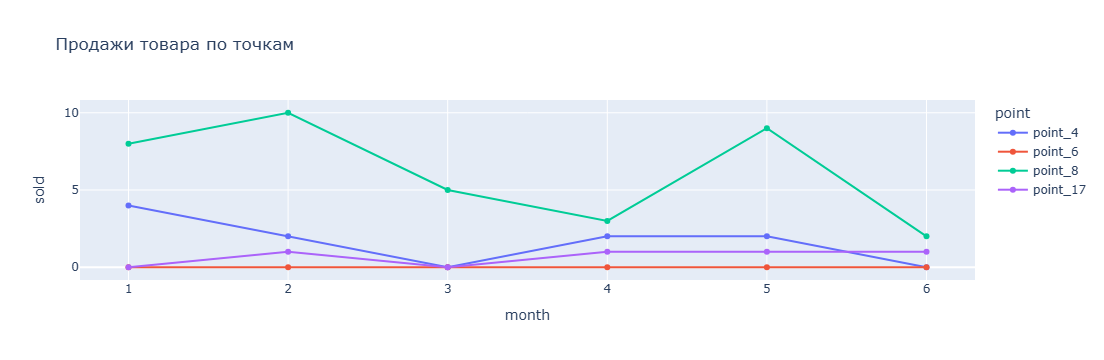

In [80]:
import plotly.express as px
product = 'Картридж fabricator_of_consumables_8 Sonder U consumables' # Задаем имя интересующего нас товара
df_4_vis = df_4[(df_4['name'] == product) & (df_4['month'] != 10)].copy() # Берем из общего ДФ данные только о нужном товаре, не рассматривая текущий месяц
df_6_vis = df_6[(df_6['name'] == product) & (df_6['month'] != 10)].copy()
df_8_vis = df_8[(df_8['name'] == product) & (df_8['month'] != 10)].copy()
df_17_vis = df_17[(df_17['name'] == product) & (df_17['month'] != 10)].copy()
df_4_vis['point'] = 'point_4' # Добавляем маркер магазина
df_6_vis['point'] = 'point_6'
df_8_vis['point'] = 'point_8'
df_17_vis['point'] = 'point_17'
df_vis = pd.concat([df_4_vis, df_6_vis, df_8_vis, df_17_vis]) # Собираем в один ДФ
# Создаем график
fig = px.line(df_vis, x='month', y='sold', color='point', markers=True, title='Продажи товара по точкам')
fig.show()

Данный проект уже внедрён в рабочие процессы и приносит реальную пользу бизнесу. Перемещение товаров между магазинами стало проще и эффективнее. Этот алгоритм частично устраняет человеческий фактор в процессе перемещения товаров: теперь вместо ручного формирования таблицы перемещений, основываясь лишь на текущих остатках, можно опираться на автоматически сформированную таблицу и при необходимости вносить ситуативные правки.

Это позволило сократить затраты на логистику, ситуаций, когда кто-то забыл доложить тот или иной товар на данный момент стало значительно меньше. Также стало значительно удобнее отслеживать неликвидные позиции. Алгоритм помог выявить группу товаров, которые ранее были упущены при ручной проверке.

В дальнейшем планируется дорабатывать проект. Будут добавлены или изменены критерии отбора на основе пожеланий бизнеса. Также есть идея выделить группу ключевых товаров, которые все время есть в наличии, имеют хорошие продажи и демонстрируют взаимную корреляцию. На их основе я хочу провести регрессионный анализ, чтобы получить усреднённую модель поведения продаж. Это позволит заранее выявлять позиции с падающим спросом и оперативно:
— перераспределять запасы,
— корректировать цены,
— запускать маркетинговые активности,
— изменять объёмы закупок.

Всё это позволит продавать товар до того, как он перейдёт в категорию неликвидных.